### Student Information
Name: 黃景焌

Student ID: 113401910

GitHub ID: MacroHubber

Kaggle name: hiiiiiiiiiii5

Kaggle private scoreboard screenshot: 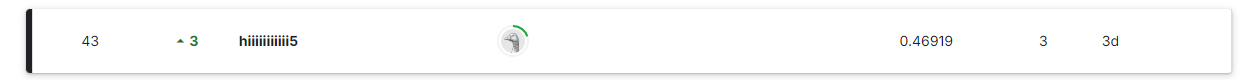

In [1]:
import json
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [2]:
import pandas as pd
emotion_df = pd.read_csv("/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv")
data_identification = pd.read_csv("/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv") 

In [3]:
tweets_df = pd.DataFrame(data)
tweets_df

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets
...,...,...,...,...,...
1867530,827,hashtag_tweets,"{'tweet': {'hashtags': ['mixedfeeling', 'butim...",2015-05-12 12:51:52,tweets
1867531,368,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x29d0...",2017-10-02 17:54:04,tweets
1867532,498,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2a6a...",2016-10-10 11:04:32,tweets
1867533,840,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x24fa...",2016-09-02 14:25:06,tweets


In [4]:
# Extract fields from the nested structure
tweets_df["tweet_id"] = tweets_df["_source"].apply(lambda x: x["tweet"]["tweet_id"])
tweets_df["text"] = tweets_df["_source"].apply(lambda x: x["tweet"]["text"])
tweets_df["hashtags"] = tweets_df["_source"].apply(lambda x: x["tweet"]["hashtags"])

# Drop the original _source column 
tweets_df = tweets_df.drop(columns=["_source"])

In [5]:
df = pd.merge(tweets_df, emotion_df, on="tweet_id", how="inner")
df.drop(columns=['_score', '_index', '_type', 'hashtags', '_crawldate'], inplace=True)

In [6]:
df

,tweet_id,text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...,...
1455558,0x321566,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy
1455559,0x38959e,In every circumtance I'd like to be thankful t...,joy
1455560,0x2cbca6,there's currently two girls walking around the...,joy
1455561,0x24faed,"Ah, corporate life, where you can date <LH> us...",joy


In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split

In [8]:
texts = df["text"].tolist()           # Raw tweet text
emotions = df["emotion"].astype("category").cat.codes.tolist()  # Encode emotions as integers

# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, emotions, test_size=0.2, random_state=42)

In [9]:
# Step 2: Initialize BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Prepare dataset
train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels})  # Use "labels" directly
val_dataset = Dataset.from_dict({"text": val_texts, "labels": val_labels})        # Use "labels" directly

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1164450 [00:00<?, ? examples/s]

Map:   0%|          | 0/291113 [00:00<?, ? examples/s]

In [11]:
# Step 3: Format Dataset for PyTorch
# Set dataset format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Step 4: Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=8)  # 8 classes

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Step 5: Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",             # Output directory
    evaluation_strategy="epoch",        # Evaluate every epoch
    per_device_train_batch_size=8,      # Batch size for training
    per_device_eval_batch_size=8,       # Batch size for evaluation
    num_train_epochs=2,                 # Number of epochs (modified to 2)
    weight_decay=0.01,                  # Strength of weight decay
    logging_dir="./logs",               # Directory for logging
    logging_steps=10,
    save_strategy="epoch",              # Save the model at each epoch
    save_total_limit=2,                 # Limit the number of saved checkpoints
    report_to=[])                        # Disable reporting to external systems



/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
subset_train_dataset = train_dataset.shuffle(seed=42).select([i for i in list(range(int(0.1 * len(train_dataset))))])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=subset_train_dataset,  # Use the subset for training
    eval_dataset=val_dataset,
)

In [14]:
# Step 7: Train the Model
trainer.train()

# Step 8: Evaluate the Model
eval_results = trainer.evaluate()
print(eval_results)

Epoch,Training Loss,Validation Loss
1,1.164100,1.142601
2,0.813100,1.128673


{'eval_loss': 1.1286729574203491, 'eval_runtime': 1135.9701, 'eval_samples_per_second': 256.268, 'eval_steps_per_second': 32.034, 'epoch': 2.0}


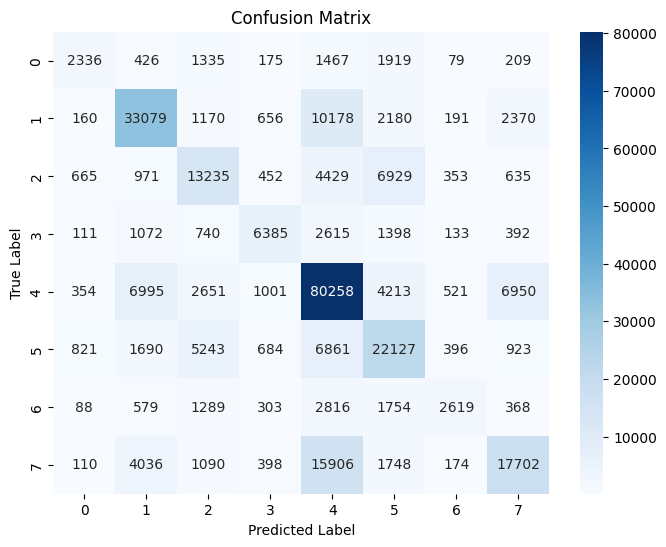

              precision    recall  f1-score   support

     Class 0       0.50      0.29      0.37      7946
     Class 1       0.68      0.66      0.67     49984
     Class 2       0.49      0.48      0.49     27669
     Class 3       0.64      0.50      0.56     12846
     Class 4       0.64      0.78      0.71    102943
     Class 5       0.52      0.57      0.55     38745
     Class 6       0.59      0.27      0.37      9816
     Class 7       0.60      0.43      0.50     41164

    accuracy                           0.61    291113
   macro avg       0.58      0.50      0.53    291113
weighted avg       0.61      0.61      0.60    291113



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get Predictions from the Validation Set
predictions = trainer.predict(val_dataset)

# Step 2: Extract Predicted and True Labels
y_pred = np.argmax(predictions.predictions, axis=1)  # Predicted labels
y_true = predictions.label_ids  # True labels

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(8), yticklabels=range(8))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Print Classification Report (Optional)
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(8)]))


In [16]:
tweets_df = pd.merge(tweets_df, data_identification, on="tweet_id", how="inner")
tweets_df

,_score,_index,_crawldate,_type,tweet_id,text,hashtags,identification
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],train
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",train
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse],test
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[],train
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,0x2de201,"""Trust is not the same as faith. A friend is s...",[],test
...,...,...,...,...,...,...,...,...
1867530,827,hashtag_tweets,2015-05-12 12:51:52,tweets,0x316b80,When you buy the last 2 tickets remaining for ...,"[mixedfeeling, butimTHATperson]",test
1867531,368,hashtag_tweets,2017-10-02 17:54:04,tweets,0x29d0cb,I swear all this hard work gone pay off one da...,[],test
1867532,498,hashtag_tweets,2016-10-10 11:04:32,tweets,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,[],test
1867533,840,hashtag_tweets,2016-09-02 14:25:06,tweets,0x24faed,"Ah, corporate life, where you can date <LH> us...",[],train


In [17]:
test_data = tweets_df[tweets_df['identification'] == 'test']
X_test_data = test_data.drop(['_score', '_index','_crawldate', '_type','hashtags', 'tweet_id', 'identification'], axis=1)

In [18]:
X_test_data

,text
2,"Confident of your obedience, I write to you, k..."
4,"""Trust is not the same as faith. A friend is s..."
9,When do you have enough ? When are you satisfi...
30,"God woke you up, now chase the day #GodsPlan #..."
33,"In these tough times, who do YOU turn to as yo..."
...,...
1867525,"""For this is the message that ye heard from th..."
1867529,"""There is a lad here, which hath five barley l..."
1867530,When you buy the last 2 tickets remaining for ...
1867531,I swear all this hard work gone pay off one da...


In [19]:
# Step 1: Prepare the test dataset from the raw text data
test_dataset = Dataset.from_dict({"text": X_test_data['text'].tolist()})  # No labels in test data

# Step 2: Apply the tokenization function to the test dataset
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/411972 [00:00<?, ? examples/s]

In [20]:
import numpy as np
from tqdm import tqdm

In [21]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast
from transformers import BertForSequenceClassification

# Set up the device and move the model to GPU
device = torch.device('cuda')
model.to(device)
model.eval()  # Set the model to evaluation mode

# Define batch size for DataLoader
batch_size = 128  # Adjust based on GPU memory and data size

# Create a DataLoader for efficient batch iteration
dataset = TensorDataset(
    torch.tensor(test_dataset["input_ids"], dtype=torch.long),
    torch.tensor(test_dataset["attention_mask"], dtype=torch.long)
)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Initialize mixed precision scaler for faster inference
scaler = torch.cuda.amp.GradScaler()

# Step 3: Make predictions using the trained BERT model
y_final_pred = []

with torch.no_grad():  # Disable gradient calculation for inference
    for batch_input_ids, batch_attention_mask in data_loader:
        # Move batch to GPU
        batch_input_ids, batch_attention_mask = batch_input_ids.to(device), batch_attention_mask.to(device)

        # Use mixed precision for faster computation
        with autocast():
            # Forward pass to get the model outputs
            test_outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            test_predictions = torch.argmax(test_outputs.logits, dim=1)  # Get predicted class indices

        # Append predictions to the result list
        y_final_pred.extend(test_predictions.cpu().numpy())

# Convert final predictions to a numpy array
y_final_pred = np.array(y_final_pred)


/tmp/ipykernel_23/1436587439.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_23/1436587439.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [22]:
print(df["emotion"].astype("category").cat.categories)

Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
       'surprise', 'trust'],
      dtype='object')


In [23]:
label_mapping = {i: label for i, label in enumerate(df["emotion"].astype("category").cat.categories)}

y_final_pred_names = [label_mapping[label] for label in y_final_pred]

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['tweet_id'],  # Assuming 'tweet_id' is the ID column in your test data
    'emotion': y_final_pred_names
})

# Save the submission file
submission.to_csv('/kaggle/working/submissionlate.csv', index=False)